# **SYS843 - Classification de fractures sur images de radiographie**

#Liste des import

In [ ]:
from google.colab import drive

import tensorflow as tf
from tensorflow.keras import layers
from skimage.io import imshow
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import time 


#Acquisition des data et création du dataset 

Le dataset MURA est conservé dans le meme dossier que ce fichier .ipynb dans Google Drive. 
Dans cette forme n'est un ensemble d'images regroupées dans différents dossiers représentant les patients. Les étiquettes de ces patients (positif ou négatif à la fracture) est indiquée dans le nom du dossier.
Il va donc falloir reformer cette base de données de façon à faire ressortir les labels des images.

De plus, la base de données de test utilisée lors du concours n'est pas accessible. nous allons donc utiliser la base de validation de la base de données en tant que base de test puis séparer la base d'entrainement en deux partie pour former notre base de validation.


**Méthode**: La base de donnée présence un fichier csv contenant les chemins d'accès de toutes les images. Nous allons tout d'abord créer un dataframe faisant correspondre ces chemins d'accès aux labels des images pour chaque base (entraînement, validation, test).
Ensuite, grâce a ces dataframes, nous allons générer des bases d'entraîmement, validation et test faisant correspondre les images et leur label

In [ ]:
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/SYS843/Projet/


Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/SYS843/Projet


In [ ]:
"""
Cette fonction crée un dataframe à partir d'un fichier csv compilant tous les chemins d'accès des images
Les labels des images correspondantes sont indiqués dans le nom du dossier les contenants : studyx_positive ou studyx_negative x étant le numéro de l'étude

@param csv_path le chemin du fichier csv contenant les chemins d'accès
@return df le dataframe contenant les chemins d'accès aux images ainsi que leur label respectif
"""
def create_dataframe(csv_path):
    df = pd.read_csv(csv_path, header=None, names=['filename'])

    df['class'] = df.filename.str.extract('study.*_(positive|negative)',expand = False) #.replace({'positive':"1",'negative':"0"},inplace = True)
    
    
    return df
     

In [ ]:
#Création des dataframes

mura_path = 'MURA-v1.1/'
project_path = '/content/gdrive/MyDrive/Colab Notebooks/SYS843/Projet/'

csv_train = 'train_image_paths.csv'
csv_valid = 'valid_image_paths.csv'

# Regroupement des dataframes en un seul contenant tous les chemin d'accès
df1 = create_dataframe(project_path+mura_path+csv_train)
df2 = create_dataframe(project_path+mura_path+csv_valid)

frames = [df1,df2]

tot_dataset = pd.concat(frames).sample(n=100)

train_df = tot_dataset.sample(frac = 0.8) # 80% du nombre d'image choisi

df_rest = tot_dataset.drop(train_df.index)

valid_df = df_rest.sample(frac = 0.5) # 50% de 20% ->10%
test_df  = df_rest.drop(valid_df.index) # 10%
 

print("Nombre de chemins d'accès total de l'expérience: ",len(train_df.index)+ len(valid_df.index)+len(test_df.index))
print("Nombre de chemins d'accès dans les bases train, valid et test respectivement  : ",len(train_df.index),len(valid_df.index),len(test_df.index))

Nombre de chemins d'accès total de l'expérience:  100
Nombre de chemins d'accès dans les bases train, valid et test respectivement  :  80 10 10


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)


#Création du dataframe de test
test_gen = datagen.flow_from_dataframe(test_df,
                                        directory=project_path,
                                        target_size=(224, 224),
                                        class_mode='binary')

#Création du dataframe d'entraînement
train_gen = datagen.flow_from_dataframe(train_df,
                                        directory=project_path,
                                        target_size=(224, 224),
                                        class_mode='binary')

#Création du dataframe de validation
valid_gen = datagen.flow_from_dataframe(valid_df,
                                        directory=project_path,
                                        target_size=(224, 224),
                                        class_mode='binary')


Found 10 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.


# Création des modèles 

Les modèles qui seront utilisés pour ce projet sont DenseNet201 et InceptionResNet-v2

##DenseNet201

In [ ]:
#Création du modèle
densenet = tf.keras.applications.DenseNet201(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

model_densenet = tf.keras.models.Sequential([
    densenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
densenet.summary()
model_densenet.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
#Creation de callbacks pour sauver les modèles des différentes epoch
cp_callback_densenet =[
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='callbacks_densenet/model_{val_loss:.2f}.ckpt'),
    tf.keras.callbacks.TensorBoard(log_dir=project_path+'logs'),
]

In [ ]:
#compilation du modèle
model_densenet.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              metrics=['accuracy'])

In [ ]:
#entrainement

epoch = 10
train_acc1 = []
val_loss1   = []
train_loss1 = []
val_acc1    = []

tim_list1 =[]

for i in range(epoch):
    print("Epoch",i,"/",epoch,":")

    tim = time.time()

    hist = model_densenet.fit(train_gen, epochs=1,batch_size = 32, validation_data=valid_gen, use_multiprocessing=True,callbacks = [cp_callback_densenet])

    tim_list1.append(time.time()-tim)

    train_acc1.extend(hist.history['accuracy'])
    val_loss1.extend(hist.history['val_loss'])
    train_loss1.extend(hist.history['loss'])
    val_acc1.extend(hist.history['val_accuracy'])

model_densenet.save("results-x/bonemodel_densenet2.ckpt")
    

Epoch 0 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.5500

3/3 [==============================] - 304s 71s/step - loss: 0.8655 - accuracy: 0.5500 - val_loss: 0.6120 - val_accuracy: 0.6000
Epoch 1 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8875

3/3 [==============================] - 134s 65s/step - loss: 0.3892 - accuracy: 0.8875 - val_loss: 0.6095 - val_accuracy: 0.6000
Epoch 2 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9625

3/3 [==============================] - 138s 66s/step - loss: 0.2402 - accuracy: 0.9625 - val_loss: 0.5917 - val_accuracy: 0.6000
Epoch 3 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 1.0000

3/3 [==============================] - 136s 65s/step - loss: 0.1360 - accuracy: 1.0000 - val_loss: 0.5613 - val_accuracy: 0.6000
Epoch 4 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 1.0000

3/3 [==============================] - 138s 67s/step - loss: 0.0813 - accuracy: 1.0000 - val_loss: 0.5339 - val_accuracy: 0.7000
Epoch 5 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 1.0000

3/3 [==============================] - 137s 66s/step - loss: 0.0553 - accuracy: 1.0000 - val_loss: 0.5085 - val_accuracy: 0.7000
Epoch 6 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 1.0000

3/3 [==============================] - 138s 66s/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.4913 - val_accuracy: 0.7000
Epoch 7 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 1.0000

3/3 [==============================] - 135s 65s/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.4790 - val_accuracy: 0.7000
Epoch 8 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 1.0000

3/3 [==============================] - 136s 65s/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.4695 - val_accuracy: 0.8000
Epoch 9 / 10 :
3/3 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 1.0000

3/3 [==============================] - 136s 65s/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.4630 - val_accuracy: 0.9000


train_acc :  [0.550000011920929, 0.887499988079071, 0.9624999761581421, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
train_loss :  [0.8654855489730835, 0.38924700021743774, 0.24024632573127747, 0.13601258397102356, 0.08133462816476822, 0.055349789559841156, 0.03753383085131645, 0.02626764215528965, 0.027226949110627174, 0.021454602479934692]
val_acc :  [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.699999988079071, 0.699999988079071, 0.699999988079071, 0.699999988079071, 0.800000011920929, 0.8999999761581421]
val_loss :  [0.6119901537895203, 0.6094896197319031, 0.5917364358901978, 0.5613102912902832, 0.5339444875717163, 0.5085068941116333, 0.49130773544311523, 0.4790347218513489, 0.46954217553138733, 0.4630165994167328]


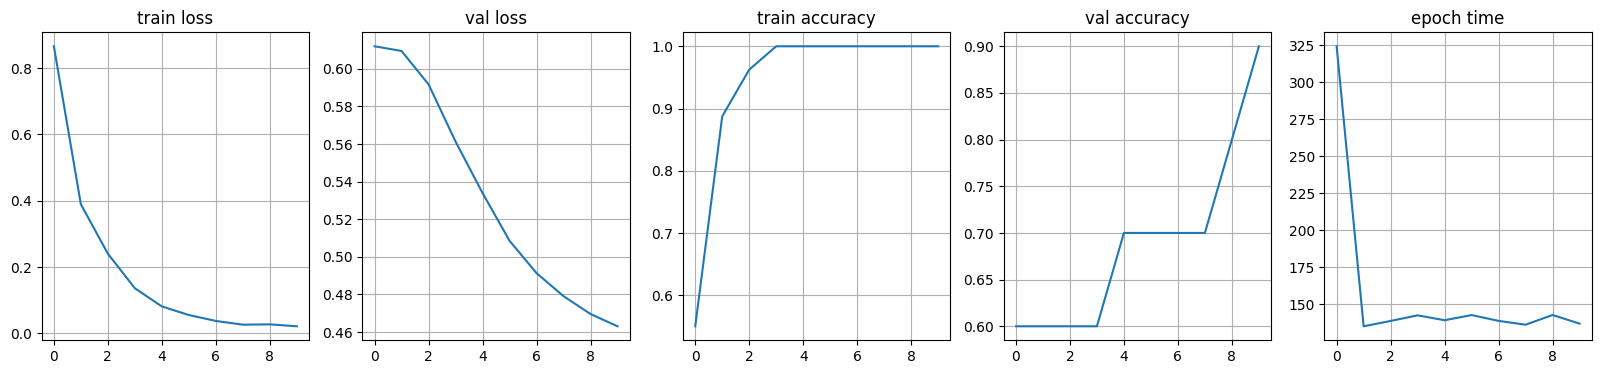

In [ ]:
#affichage et sauvegarde des graphes d'entraînement

figure = plt.figure(figsize = (20,4))
xc = range(epoch)

figure.add_subplot(1,5,1)
plt.plot(xc,train_loss1)
plt.title("train loss")
plt.grid()

figure.add_subplot(1,5,2)
plt.plot(xc,val_loss1)
plt.title("val loss")
plt.grid()

figure.add_subplot(1,5,3)
plt.plot(xc,train_acc1)
plt.title("train accuracy")
plt.grid()

figure.add_subplot(1,5,4)
plt.plot(xc,val_acc1)
plt.title("val accuracy")
plt.grid()

figure.add_subplot(1,5,5)
plt.plot(xc,tim_list1)
plt.title("epoch time")
plt.grid()

plt.savefig('results-x/densenet_training_results2.png')

print("train_acc : ",train_acc1)
print("train_loss : ",train_loss1)
print("val_acc : ",val_acc1)
print("val_loss : ", val_loss1)

In [ ]:
# Evaluation du modèle du la base de test
print("Evaluate on test data")
results = model_densenet.evaluate(test_gen, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 186ms/step - loss: 0.6719 - accuracy: 0.6000
test loss, test acc: [0.6718770861625671, 0.6000000238418579]


##Inception-ResNet-v2

In [ ]:
#création du modèle
inceptionresnetv2 = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape=(224,224,3))

model_inception = tf.keras.models.Sequential([
    inceptionresnetv2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
inceptionresnetv2.summary()
model_inception.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
#compilation du modèle
model_inception.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [ ]:
# Create a callback that saves the model's weights
cp_callback_inception =[
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='callback_inception/model-{val_loss:.2f}.ckpt'),
    tf.keras.callbacks.TensorBoard(log_dir=project_path+'logs'),
]

In [ ]:
#entraînement
epoch = 10
train_acc = []
val_loss   = []
train_loss  = []
val_acc    = []

tim_list =[]

for i in range(epoch):
    print("Epoch",i,"/",epoch,":")
    tim = time.time()
    
    hist = model_inception.fit(train_gen, epochs=1, validation_data=valid_gen, use_multiprocessing=True, callbacks = [cp_callback_inception])

    tim_list.append(time.time()-tim)

    train_acc.extend(hist.history['accuracy'])
    val_loss.extend(hist.history['val_loss'])
    train_loss.extend(hist.history['loss'])
    val_acc.extend(hist.history['val_accuracy'])

model_inception.save("results-x/bonemodel_inception.ckpt")

Epoch 0 / 10 :


NameError: ignored

In [ ]:
#affichage et sauvegarde des graphes d'entraînement
figure = plt.figure(figsize = (20,4))
xc = range(epoch)

figure.add_subplot(1,5,1)
plt.plot(xc,train_loss)
plt.title("train loss")
plt.grid()

figure.add_subplot(1,5,2)
plt.plot(xc,val_loss)
plt.title("val loss")
plt.grid()

figure.add_subplot(1,5,3)
plt.plot(xc,train_acc)
plt.title("train accuracy")
plt.grid()

figure.add_subplot(1,5,4)
plt.plot(xc,val_acc)
plt.title("val accuracy")
plt.grid()

figure.add_subplot(1,5,5)
plt.plot(xc,tim_list)
plt.title("epoch time")
plt.grid()

plt.savefig('results-x/inceptionresnet_training_results.png')

print("train_acc : ",train_acc)
print("train_loss : ",train_loss)
print("val_acc : ",val_acc)
print("val_loss : ", val_loss)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_inception.evaluate(test_gen, batch_size=128)
print("test loss, test acc:", results)